In [1]:
# Import libraries
from library.common import Database
import pathlib

import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
# import seaborn as sns 
import altair as alt
import warnings
warnings.filterwarnings("ignore")
#from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from linearmodels import PanelOLS
from linearmodels import RandomEffects

# Display all columns of pandas dataframes
pd.set_option('display.max_columns', None)

db = Database()
write_to_db = True

# Get the path to raw data files
# path = pathlib.Path.cwd().parent.joinpath(path_to_data)

Read the consolidated_data from Database

In [2]:
data2 = pd.read_sql('consolidated_data', db.config)

Set countries coverage and define 'developed countries'

In [3]:
country_target=['AGO', 'ALB', 'ARE', 'ARG', 'ARM', 'AUS', 'AUT', 'AZE', 'BEL', 'BEN', 'BGD', 'BGR', 'BHR', 'BIH', 'BLR', 'BOL',
                'BRA', 'BRN', 'BWA', 'CAN', 'CHE', 'CHL', 'CHN', 'CIV', 'CMR', 'COD', 'COG', 'COL', 'CRI', 'CUB', 'CYP',
                'CZE', 'DEU', 'DNK', 'DOM', 'DZA', 'ECU', 'EGY', 'ESP', 'EST', 'ETH', 'FIN', 'FRA', 'GAB', 'GBR', 'GEO', 'GHA',
                'GRC', 'GTM', 'HKG', 'HND', 'HRV', 'HTI', 'HUN', 'IDN', 'IND', 'IRL', 'IRN', 'IRQ', 'ISL', 'ISR', 'ITA', 'JAM',
                'JOR', 'JPN', 'KAZ', 'KEN', 'KGZ', 'KHM', 'KOR', 'LBN', 'LBY', 'LKA', 'LTU', 'LUX', 'LVA', 'MAR', 'MDA', 'MEX',
                'MLT', 'MMR', 'MNE', 'MNG', 'MOZ', 'MUS', 'MYS', 'NAM', 'NER', 'NGA', 'NIC', 'NLD', 'NOR', 'NPL', 'NZL',
                'OMN', 'PAK', 'PAN', 'PER', 'PHL', 'POL', 'PRK', 'PRT', 'PRY', 'QAT', 'ROU', 'SAU', 'SDN', 'SEN', 'SLV', 'SRB',
                'SUR', 'SVK', 'SVN', 'SWE', 'SYR', 'TGO', 'THA', 'TJK', 'TKM', 'TTO', 'TUN', 'TUR', 'TZA', 'UKR', 'URY',
                'USA', 'UZB', 'VEN', 'VNM', 'XKX', 'ZAF', 'RUS', 'SGP'] #They are chosen because they have more complete data

developed_country=['AUS','AUT','BEL','CAN','CHE','DEU','DNK','ESP','FIN','FRA','GBR','GRC','HKG','IRL','ISL','ISR','ITA',
                   'JPN','KOR','LUX','NLD','NOR','NZL','PRT','SGP','SWE','USA'] #Just leave it at the moment

Only use data from 1971 because many variables like energy consumption only starts from 1971
(CO2 Emission, Population, Urban Population percentage, GDP have 1960 - 1969 figures)

In [4]:
analysis_df=data2[(data2['Year']>=1971)&(data2['Country Code']!='WLD')]
analysis_df=analysis_df.loc[analysis_df['Country Code'].isin(country_target)]
analysis_df['Developed']=np.where(analysis_df['Country Code'].isin(developed_country),1,0)
col_use = ['Year','Country Code','region','income_group','CO2 Emission','CO2 Emission per capita','CO2 Emission per constant GDP',
           'Population','Urban Population Percent','Constant GDP per capita','Manufacturing Percent','Manufacturing Country Share Percent',
           'Manufacturer Export Share','Trade Openness','Share of Merchandise Import','Share of Merchandise Export','Primary Energy Consumption per capita',
           'Renewable Energy Consumption Share','Percent of Environment Patent','Energy Intensity','Current GDP','Constant GDP',
           'Merchandise Export','Merchandise Import','Developed']
analysis_df=analysis_df[col_use]

# Take log on independent and dependent variables
analysis_df['log_total_co2']=np.log(analysis_df['CO2 Emission'])
analysis_df['log_co2_per_capita']=np.log(analysis_df['CO2 Emission per capita'])
analysis_df['log_co2_intensity']=np.log(analysis_df['CO2 Emission per constant GDP'])
analysis_df['log_population']=np.log(analysis_df['Population'])
analysis_df['log_urban_percent']=np.log(analysis_df['Urban Population Percent'])
analysis_df['log_gdp_per_capita']=np.log(analysis_df['Constant GDP per capita'])
#analysis_df['log_gdp_per_capita_sq']=np.log(analysis_df['Constant GDP per capita'])*np.log(analysis_df['Constant GDP per capita'])
analysis_df['log_manufacturing_share']=np.log(analysis_df['Manufacturing Percent'])
analysis_df['log_global_manufacturing_share']=np.log(analysis_df['Manufacturing Country Share Percent'])
analysis_df['log_trade']=np.log(analysis_df['Trade Openness'])
analysis_df['log_energy_intensity']=np.log(analysis_df['Energy Intensity'])
analysis_df['log_renewable_share']=np.log(analysis_df['Renewable Energy Consumption Share'])
#analysis_df['log_renewable_share_sq']=np.log(analysis_df['Renewable Energy Consumption Share'])*np.log(analysis_df['Renewable Energy Consumption Share'])
analysis_df['log_patent_percent']=np.log(analysis_df['Percent of Environment Patent'])

# Compute interaction terms for log terms
analysis_df['log_pop_dev']=analysis_df['log_population']*analysis_df['Developed']
analysis_df['log_urb_dev']=analysis_df['log_urban_percent']*analysis_df['Developed']
analysis_df['log_gdp_dev']=analysis_df['log_gdp_per_capita']*analysis_df['Developed']
#analysis_df['log_gdp2_dev']=analysis_df['log_gdp_per_capita_sq']*analysis_df['Developed']
analysis_df['log_ei_dev']=analysis_df['log_energy_intensity']*analysis_df['Developed']
analysis_df['log_man_dev']=analysis_df['log_manufacturing_share']*analysis_df['Developed']
analysis_df['log_gman_dev']=analysis_df['log_global_manufacturing_share']*analysis_df['Developed']
analysis_df['log_trade_dev']=analysis_df['log_trade']*analysis_df['Developed']
analysis_df['log_renew_dev']=analysis_df['log_renewable_share']*analysis_df['Developed']
#analysis_df['log_renew2_dev']=analysis_df['log_renewable_share_sq']*analysis_df['Developed']
analysis_df['log_patent_dev']=analysis_df['log_patent_percent']*analysis_df['Developed']
#analysis_df['Constant GDP Sq']=analysis_df['Constant GDP per capita']*analysis_df['Constant GDP per capita']
#analysis_df['Renewable Sq']=analysis_df['Renewable Energy Consumption Share']*analysis_df['Renewable Energy Consumption Share']

# Compute interaction terms for original terms
analysis_df['Int1']=analysis_df['Urban Population Percent']*analysis_df['Developed']
analysis_df['Int2']=analysis_df['Constant GDP per capita']*analysis_df['Developed']
#analysis_df['Int3']=analysis_df['Constant GDP Sq']*analysis_df['Developed']
analysis_df['Int4']=analysis_df['Energy Intensity']*analysis_df['Developed']
analysis_df['Int5']=analysis_df['Manufacturing Percent']*analysis_df['Developed']
analysis_df['Int6']=analysis_df['Manufacturing Country Share Percent']*analysis_df['Developed']
analysis_df['Int7']=analysis_df['Trade Openness']*analysis_df['Developed']
analysis_df['Int8']=analysis_df['Renewable Energy Consumption Share']*analysis_df['Developed']
#analysis_df['Int9']=analysis_df['Renewable Sq']*analysis_df['Developed']
analysis_df['Int10']=analysis_df['Percent of Environment Patent']*analysis_df['Developed']

In [5]:
# Analyse only 2000 - 2018 data because (i) renewable energy only become more widespread use after 2000, (ii) structural change
# in world trade after China's entering WTO; (iii) patent data do not have 2019 and 2020 information

# Subset dataframe
analysis_2000_df=analysis_df[(analysis_df['Year']>=2000)&(analysis_df['Year']<=2018)&(analysis_df['Country Code']!='WLD')]
analysis_2000_df2 = analysis_2000_df.copy(deep=True)
analysis_2000_df2 = analysis_2000_df2.dropna(subset=['log_urban_percent','log_gdp_per_capita','log_energy_intensity',
                                                     'log_manufacturing_share','log_global_manufacturing_share','log_trade','log_renewable_share',
                                                     'log_patent_percent','log_urb_dev','log_gdp_dev','log_ei_dev','log_man_dev','log_gman_dev',
                                                     'log_trade_dev','log_renew_dev','log_patent_dev'])
# Prepare the dataframe for panel regression
analysis_2000_df=analysis_2000_df.set_index(['Country Code','Year'])

years = analysis_2000_df.index.get_level_values('Year').to_list()
analysis_2000_df['Year'] = pd.Categorical(years)

analysis_2000_df

,,region,income_group,CO2 Emission,CO2 Emission per capita,CO2 Emission per constant GDP,Population,Urban Population Percent,Constant GDP per capita,Manufacturing Percent,Manufacturing Country Share Percent,Manufacturer Export Share,Trade Openness,Share of Merchandise Import,Share of Merchandise Export,Primary Energy Consumption per capita,Renewable Energy Consumption Share,Percent of Environment Patent,Energy Intensity,Current GDP,Constant GDP,Merchandise Export,Merchandise Import,Developed,log_total_co2,log_co2_per_capita,log_co2_intensity,log_population,log_urban_percent,log_gdp_per_capita,log_manufacturing_share,log_global_manufacturing_share,log_trade,log_energy_intensity,log_renewable_share,log_patent_percent,log_pop_dev,log_urb_dev,log_gdp_dev,log_ei_dev,log_man_dev,log_gman_dev,log_trade_dev,log_renew_dev,log_patent_dev,Int1,Int2,Int4,Int5,Int6,Int7,Int8,Int10,Year
Country Code,Year,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
AGO,2000,Sub-Saharan Africa,Lower middle income,9516.0,0.580404,0.237352,16395477.0,50.087,2445.328881,2.889839,0.006011,NaN,114.086915,24.903020,64.887113,438.549912,73.441101,NaN,0.179342,1.220735e+10,4.009233e+10,7.921000e+09,3.040000e+09,0,9.160730,-0.544031,-1.438211,16.612516,3.913761,7.801935,1.061201,-5.114127,4.736961,-1.718461,4.296484,NaN,0.0,0.0,0.0,-0.0,0.0,-0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,2000
ALB,2000,Europe & Central Asia,Upper middle income,3004.0,0.972475,0.495935,3089027.0,41.741,1960.891864,4.317876,0.002566,81.831820,63.322673,31.282380,7.483686,580.494764,41.445000,NaN,0.296036,3.487586e+09,6.057248e+09,2.610000e+08,1.091000e+09,0,8.007700,-0.027911,-0.701311,14.943367,3.731484,7.581155,1.462764,-5.965393,4.148243,-1.217274,3.724367,NaN,0.0,0.0,0.0,-0.0,0.0,-0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,2000
ARE,2000,Middle East & North Africa,High income,111787.0,35.668350,0.588353,3134067.0,80.236,60624.102803,11.516242,0.208010,2.309004,NaN,33.027358,47.014151,10057.918990,0.076400,4.53,0.165906,1.060000e+11,1.900000e+11,4.983500e+10,3.500900e+10,0,11.624351,3.574264,-0.530429,14.957842,4.384972,11.012448,2.443758,-1.570169,NaN,-1.796332,-2.571773,1.510722,0.0,0.0,0.0,-0.0,0.0,-0.0,NaN,-0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,2000
ARG,2000,Latin America & Caribbean,Upper middle income,142358.0,3.860996,0.331837,36870796.0,89.142,11635.224800,14.009143,0.735241,32.389488,20.874622,8.166883,8.552273,1669.526337,9.848000,3.81,0.143489,3.080000e+11,4.290000e+11,2.634100e+10,2.515400e+10,0,11.866100,1.350925,-1.103112,17.422930,4.490231,9.361792,2.639710,-0.307556,3.038534,-1.941497,2.287268,1.337629,0.0,0.0,0.0,-0.0,0.0,-0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2000
ARM,2000,Europe & Central Asia,Upper middle income,3491.0,1.137283,0.895519,3069597.0,64.666,1269.970769,15.826771,0.005498,41.162311,67.734242,43.266369,14.422123,656.307652,7.162900,NaN,0.516790,2.038535e+09,3.898298e+09,2.940000e+08,8.820000e+08,0,8.157944,0.128642,-0.110352,14.937057,4.169236,7.146749,2.761703,-5.203432,4.215592,-0.660120,1.968915,NaN,0.0,0.0,0.0,-0.0,0.0,-0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,2000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
UZB,2018,Europe & Central Asia,Lower middle income,114732.0,3.481359,1.199498,32956100.0,50.478,2902.345422,16.961028,0.062129,25.116857,66.627978,34.354242,21.671827,1275.426358,1.487500,33.33,0.439447,5.039261e+10,9.564999e+10,1.092100e+10,1.731200e+10,0,11.650354,1.247423,0.181903,17.310687,3.921538,7.973274,2.830918,-2.778549,4.199125,-0.822239,0.397097,3.506458,0.0,0.0,0.0,-0.0,0.0,-0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2018
VEN,2018,Latin America & Caribbean,Upper middle income,120177.0,4.160228,0.619469,28887117.0,88.208,6715.796526,14.673327,0.217586,NaN,NaN,5.740196,16.882353,1611.806014,14.564700,20.21,0.240002,2.040000e+

In [6]:
# Model 1: CO2 per capita
# Set dependent variables
co2_pc_exog_vars=['log_urban_percent','log_gdp_per_capita','log_energy_intensity',
                  'log_manufacturing_share','log_global_manufacturing_share','log_trade','log_renewable_share',
                  'log_patent_percent','log_urb_dev','log_gdp_dev','log_ei_dev','log_man_dev','log_gman_dev',
                  'log_trade_dev','log_renew_dev','log_patent_dev'
                 ]
exog=analysis_2000_df[co2_pc_exog_vars]
# Run fixed-effect model - Dependent variable is CO2 per capita
model_fe_2000_co2_pc = PanelOLS(analysis_2000_df['log_co2_per_capita'], exog, entity_effects=True, time_effects=True) 
model_fe_2000_co2_pc_result = model_fe_2000_co2_pc.fit(cov_type='clustered',cluster_entity=True,cluster_time=True) 
print(model_fe_2000_co2_pc_result)

                          PanelOLS Estimation Summary                           
Dep. Variable:     log_co2_per_capita   R-squared:                        0.6873
Estimator:                   PanelOLS   R-squared (Between):             -11.716
No. Observations:                1762   R-squared (Within):               0.6743
Date:                Fri, Nov 19 2021   R-squared (Overall):             -9.2296
Time:                        11:58:59   Log-likelihood                    1819.6
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      220.25
Entities:                         125   P-value                           0.0000
Avg Obs:                       14.096   Distribution:                 F(16,1603)
Min Obs:                       1.0000                                           
Max Obs:                       19.000   F-statistic (robust):             40.011
                            

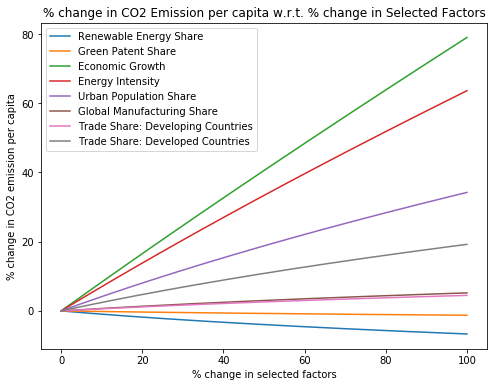

In [7]:
# Visualize elasticity effect
elasticity_df=pd.DataFrame()
x_2=np.arange(start=0, stop=1.0001, step=0.0001)
x=(x_2+1).tolist()
elasticity_df['Factor']=x
elasticity_df['Renewable Energy Share']=elasticity_df['Factor']**model_fe_2000_co2_pc_result.params[6]
elasticity_df['Green Patent Share']=elasticity_df['Factor']**model_fe_2000_co2_pc_result.params[7]
elasticity_df['Economic Growth']=elasticity_df['Factor']**model_fe_2000_co2_pc_result.params[1]
elasticity_df['Energy Intensity']=elasticity_df['Factor']**model_fe_2000_co2_pc_result.params[2]
elasticity_df['Urban Population Share']=elasticity_df['Factor']**model_fe_2000_co2_pc_result.params[0]
elasticity_df['Global Manufacturing Share']=elasticity_df['Factor']**model_fe_2000_co2_pc_result.params[4]
elasticity_df['Trade Share_Developing']=elasticity_df['Factor']**model_fe_2000_co2_pc_result.params[5]
elasticity_df['Trade Share_Developed']=elasticity_df['Factor']**(model_fe_2000_co2_pc_result.params[5]+model_fe_2000_co2_pc_result.params[13])

plt.figure(figsize=(8, 6))
plt.title('% change in CO2 Emission per capita w.r.t. % change in Selected Factors')
plt.xlabel('% change in selected factors')
plt.ylabel('% change in CO2 emission per capita')
plt.plot((elasticity_df['Factor']-1)*100,(elasticity_df['Renewable Energy Share']-1)*100)
plt.plot((elasticity_df['Factor']-1)*100,(elasticity_df['Green Patent Share']-1)*100)
plt.plot((elasticity_df['Factor']-1)*100,(elasticity_df['Economic Growth']-1)*100)
plt.plot((elasticity_df['Factor']-1)*100,(elasticity_df['Energy Intensity']-1)*100)
plt.plot((elasticity_df['Factor']-1)*100,(elasticity_df['Urban Population Share']-1)*100)
plt.plot((elasticity_df['Factor']-1)*100,(elasticity_df['Global Manufacturing Share']-1)*100)
plt.plot((elasticity_df['Factor']-1)*100,(elasticity_df['Trade Share_Developing']-1)*100)
plt.plot((elasticity_df['Factor']-1)*100,(elasticity_df['Trade Share_Developed']-1)*100)
plt.legend(labels=['Renewable Energy Share','Green Patent Share','Economic Growth','Energy Intensity','Urban Population Share','Global Manufacturing Share','Trade Share: Developing Countries','Trade Share: Developed Countries'])
plt.show()

In [8]:
residuals_fe_2000_co2_pc = model_fe_2000_co2_pc_result.resids
residuals_fe_2000_co2_pc_df=residuals_fe_2000_co2_pc.to_frame().reset_index()
residuals_fe_2000_co2_pc_df=pd.merge(residuals_fe_2000_co2_pc_df,analysis_2000_df2[['log_co2_per_capita','Country Code','Year']],how='left',on=['Country Code','Year']) 
residuals_fe_2000_co2_pc_df['predicted']=residuals_fe_2000_co2_pc_df['log_co2_per_capita']-residuals_fe_2000_co2_pc_df['residual']
residuals_fe_2000_co2_pc_df

,Country Code,Year,residual,log_co2_per_capita,predicted
0,ARG,2000,-0.048659,1.350925,1.399584
1,AUS,2000,-0.033128,2.910660,2.943788
2,AUT,2000,0.004712,2.110872,2.106161
3,AZE,2000,0.146755,1.299095,1.152340
4,BEL,2000,-0.016598,2.514580,2.531179
...,...,...,...,...,...
1757,URY,2018,-0.202433,0.644498,0.846931
1758,USA,2018,0.025675,2.800140,2.774465
1759,UZB,2018,0.013960,1.247423,1.233463
1760,VNM,2018,-0.045966,0.850779,0.896745


In [9]:
# Try doing by adding dummies explicitly (cross-check)
co2_pc_exog_vars_hand=['Country Code','Year','log_urban_percent','log_gdp_per_capita','log_energy_intensity',
                       'log_manufacturing_share','log_global_manufacturing_share','log_trade','log_renewable_share',
                       'log_patent_percent','log_urb_dev','log_gdp_dev','log_ei_dev','log_man_dev','log_gman_dev',
                       'log_trade_dev','log_renew_dev','log_patent_dev'
                      ]
exog_hand=analysis_2000_df2[co2_pc_exog_vars_hand]
country_lst=list(exog_hand['Country Code'].unique())[1:]

for i in range(2001,2019):
    exog_hand[i]=np.where(exog_hand['Year']==i,1,0)
for country in country_lst:
    exog_hand[country]=np.where(exog_hand['Country Code']==country,1,0)
exog_hand.drop(['Year'],axis=1,inplace=True)
exog_hand2=exog_hand.copy(deep=True)
exog_hand.drop(['Country Code'],axis=1,inplace=True)
mod_2000_co2_pc = sm.OLS(analysis_2000_df2['log_co2_per_capita'],sm.add_constant(exog_hand))
mod_2000_co2_pc_res = mod_2000_co2_pc.fit(cov_type='HC3')
print(mod_2000_co2_pc_res.summary())

                            OLS Regression Results                            
Dep. Variable:     log_co2_per_capita   R-squared:                       0.994
Model:                            OLS   Adj. R-squared:                  0.993
Method:                 Least Squares   F-statistic:                     4735.
Date:                Fri, 19 Nov 2021   Prob (F-statistic):               0.00
Time:                        11:58:59   Log-Likelihood:                 1819.6
No. Observations:                1762   AIC:                            -3321.
Df Residuals:                    1603   BIC:                            -2451.
Df Model:                         158                                         
Covariance Type:                  HC3                                         
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const       

In [10]:
# Check in-sample prediction
exog_hand_CHN = exog_hand2[exog_hand2['Country Code'] == 'CHN']
exog_hand_CHN .replace('CHN', 1, inplace=True)
mod_2000_co2_pc_params=mod_2000_co2_pc_res.params
in_sample_predict_hand_CHN=mod_2000_co2_pc_res.predict(exog=exog_hand_CHN)
in_sample_predict_hand_CHN=in_sample_predict_hand_CHN.to_frame()
in_sample_predict_hand_CHN.columns=['predicted']
year_lst=list(range(2000,2019))
in_sample_predict_hand_CHN['Year']=year_lst
from itertools import repeat
given_value ='CHN'
new_list=[]
new_list.extend(repeat(given_value,19))
in_sample_predict_hand_CHN['Country Code']=new_list
in_sample_predict_hand_CHN
# Compare true and predict value
analysis_2000_df2_CHN = analysis_2000_df2[analysis_2000_df2['Country Code']=='CHN']
true_hand_CHN=analysis_2000_df2_CHN[['log_co2_per_capita','Country Code','Year']]
compare_CHN=pd.merge(true_hand_CHN,in_sample_predict_hand_CHN,how='left',on=['Country Code','Year'])
compare_CHN[['Country Code','Year','log_co2_per_capita','predicted']]

,Country Code,Year,log_co2_per_capita,predicted
0,CHN,2000,1.002016,0.957994
1,CHN,2001,1.016548,0.984055
2,CHN,2002,1.106752,1.069580
3,CHN,2003,1.260630,1.220322
4,CHN,2004,1.393876,1.345923
5,CHN,2005,1.505749,1.449605
6,CHN,2006,1.599273,1.538946
7,CHN,2007,1.666822,1.637623
8,CHN,2008,1.733328,1.660926
9,CHN,2009,1.779031,1.738078


In [11]:
# Same as those obtained from PanelOLS function
b=residuals_fe_2000_co2_pc_df[residuals_fe_2000_co2_pc_df['Country Code']=='CHN']
b

,Country Code,Year,residual,log_co2_per_capita,predicted
12,CHN,2000,0.044022,1.002016,0.957994
89,CHN,2001,0.032493,1.016548,0.984055
170,CHN,2002,0.037172,1.106752,1.069580
247,CHN,2003,0.040307,1.260630,1.220322
331,CHN,2004,0.047953,1.393876,1.345923
421,CHN,2005,0.056144,1.505749,1.449605
517,CHN,2006,0.060326,1.599273,1.538946
611,CHN,2007,0.029198,1.666822,1.637623
703,CHN,2008,0.072403,1.733328,1.660926
803,CHN,2009,0.040953,1.779031,1.738078


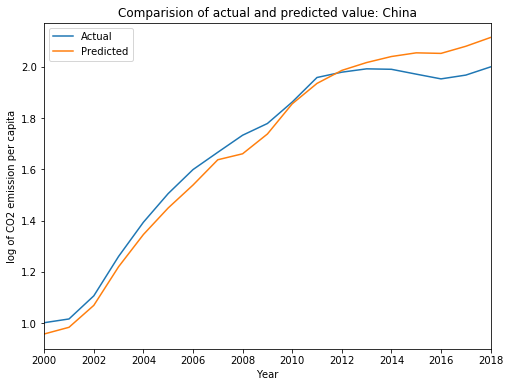

In [12]:
plt.figure(figsize=(8, 6))
plt.title('Comparision of actual and predicted value: China')
plt.xlabel('Year')
plt.ylabel('log of CO2 emission per capita')
plt.plot(b['Year'],b['log_co2_per_capita'])
plt.plot(b['Year'],b['predicted'])
plt.xlim(2000,2018)
plt.legend(labels=['Actual','Predicted'])
plt.show()

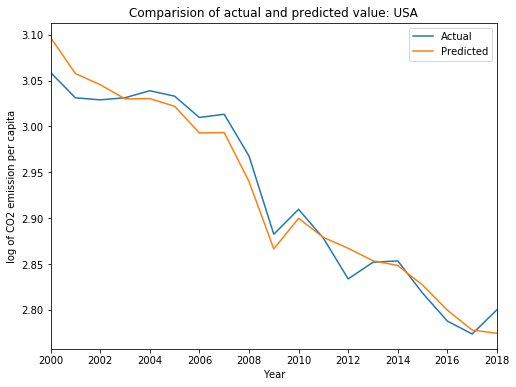

In [16]:
c=residuals_fe_2000_co2_pc_df[residuals_fe_2000_co2_pc_df['Country Code']=='USA']
plt.figure(figsize=(8, 6))
plt.title('Comparision of actual and predicted value: USA')
plt.xlabel('Year')
plt.ylabel('log of CO2 emission per capita')
plt.plot(c['Year'],c['log_co2_per_capita'])
plt.plot(c['Year'],c['predicted'])
plt.xlim(2000,2018)
plt.legend(labels=['Actual','Predicted'])
plt.show()

In [14]:
# Hausman Test function
import numpy.linalg as la
from scipy import stats
import numpy as np
def hausman(fe, re):
    b = fe.params
    B = re.params
    v_b = fe.cov
    v_B = re.cov
    df = b[np.abs(b) < 1e8].size
    chi2 = np.dot((b - B).T, la.inv(v_b - v_B).dot(b - B))  
    pval = stats.chi2.sf(chi2, df)
    return chi2, df, pval

In [15]:
# Test for Model 1
# H0 is rejected, so fixed-effect model is better
model_re_2000_co2_pc = RandomEffects(analysis_2000_df['log_co2_per_capita'], exog) 
re_res = model_re_2000_co2_pc.fit() 
hausman_results = hausman(model_fe_2000_co2_pc_result, re_res) 
print('chi-squared: ' + str(hausman_results[0]))
print('degrees of freedom: ' + str(hausman_results[1]))
print('p Value: ' + str(hausman_results[2]))

chi-squared: 61.69292333019006
degrees of freedom: 16
p Value: 2.7071622578319133e-07
